In [18]:
import os
import json


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

import keras
import tensorflow as tf


Populating the interactive namespace from numpy and matplotlib


In [19]:
from importlib import reload

In [20]:
import training_utils
reload(training_utils)

<module 'training_utils' from '/home/connor/iMaterialist_Challenge/training_utils.py'>

In [4]:
from keras import Model, Input
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, Sequence

from keras.applications import InceptionV3,inception_v3
from keras.applications import VGG16, vgg16
from sklearn.metrics import f1_score

In [10]:
labels = json.load(open('data/reformatted_train.json'))


In [11]:
y = [labels[str(x)]['labelId'] for x in range(1,10000)]
y = [[int(x) for x in a] for a in y]
largest = 0
for l in y:
    for num in l:
        if num > largest:
            largest = num
NUM_CLASSES = largest
print(largest)

228


In [6]:
# "first stupid model" this is basically just the pretrained convolutional layers with a 1000 unit 
# fully connected layer before the dense output layer. The output layer is a sigmoid rather than a softmax as the 
# problem is a multi-label multi-class problem

def create_model(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = Flatten()(X)
    X = Dense(1000, activation = 'relu', name = 'dense1')(X)
    X = Dense(1000, activation = 'relu', name = 'dense2')(X)
    predictions = Dense(NUM_CLASSES, activation = 'sigmoid', name = 'outlayer')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

In [12]:
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [13]:
iv3model = create_model(inception_base)

In [14]:
sgd = keras.optimizers.SGD(lr = .01, decay = .00001)
#rmsprop = keras.optimizers.RMSprop(lr = .01, decay = .00001)
#adam = keras.optimizers.Adam(lr = .001, decay = .00001)

In [25]:
#training_gen = data_gen.flow(X_train,y_train,seed = 42)
training_gen,Xval,yval = training_utils.create_sequence_and_val(labels,1000,10,inception_v3.preprocess_input)

In [26]:
iv3model.compile(optimizer = sgd, loss =  keras.losses.binary_crossentropy , metrics = ['accuracy'])

In [27]:
iv3model.fit_generator(training_gen,
                     epochs = 10,
                     steps_per_epoch= 10, 
                     validation_data = (Xval,yval),
                     workers = 4,
                     use_multiprocessing = True,
                     verbose = 1)

Epoch 1/10


StopIteration: Error sending result: '(array([[[[ 0.23921573,  0.2313726 ,  0.27058828],
         [ 0.17647064,  0.17647064,  0.19215691],
         [ 0.09019613,  0.09803927,  0.05882359],
         ...,
         [ 0.6784314 ,  0.5686275 ,  0.56078434],
         [ 0.64705884,  0.5372549 ,  0.5294118 ],
         [ 0.5764706 ,  0.4666667 ,  0.45882356]],

        [[ 0.22352946,  0.22352946,  0.22352946],
         [ 0.21568632,  0.21568632,  0.20000005],
         [ 0.20784318,  0.21568632,  0.17647064],
         ...,
         [ 0.67058825,  0.56078434,  0.5529412 ],
         [ 0.67058825,  0.56078434,  0.5529412 ],
         [ 0.7411765 ,  0.6313726 ,  0.62352943]],

        [[ 0.14509809,  0.15294123,  0.10588241],
         [ 0.19215691,  0.20000005,  0.15294123],
         [ 0.27058828,  0.27843142,  0.2313726 ],
         ...,
         [ 0.64705884,  0.5372549 ,  0.5294118 ],
         [ 0.6313726 ,  0.52156866,  0.5137255 ],
         [ 0.7254902 ,  0.6156863 ,  0.60784316]],

        ...,

        [[ 0.20784318,  0.20784318,  0.20784318],
         [ 0.39607847,  0.39607847,  0.39607847],
         [ 0.33333337,  0.33333337,  0.33333337],
         ...,
         [ 0.49803925,  0.49803925,  0.49803925],
         [ 0.41960788,  0.41960788,  0.41960788],
         [ 0.5294118 ,  0.5294118 ,  0.5294118 ]],

        [[ 0.36470592,  0.36470592,  0.36470592],
         [ 0.30196083,  0.30196083,  0.30196083],
         [ 0.43529415,  0.43529415,  0.43529415],
         ...,
         [ 0.49803925,  0.49803925,  0.49803925],
         [ 0.4901961 ,  0.4901961 ,  0.4901961 ],
         [ 0.45098042,  0.45098042,  0.45098042]],

        [[ 0.38823533,  0.38823533,  0.38823533],
         [ 0.3176471 ,  0.3176471 ,  0.3176471 ],
         [ 0.45882356,  0.45882356,  0.45882356],
         ...,
         [ 0.54509807,  0.54509807,  0.54509807],
         [ 0.5137255 ,  0.5137255 ,  0.5137255 ],
         [ 0.3176471 ,  0.3176471 ,  0.3176471 ]]],


       [[[ 0.6313726 ,  0.4039216 ,  0.26274514],
         [ 0.60784316,  0.34901965,  0.21568632],
         [ 0.7411765 ,  0.45098042,  0.30980396],
         ...,
         [-0.08235294, -0.372549  , -0.6       ],
         [-0.01176471, -0.35686272, -0.5686275 ],
         [-0.03529412, -0.38039213, -0.5921569 ]],

        [[ 0.99215686,  0.7490196 ,  0.52156866],
         [ 0.85882354,  0.5921569 ,  0.37254906],
         [ 0.9607843 ,  0.67058825,  0.4431373 ],
         ...,
         [-0.06666666, -0.38823527, -0.60784316],
         [-0.04313725, -0.41176468, -0.64705884],
         [-0.00392157, -0.372549  , -0.60784316]],

        [[ 0.9372549 ,  0.67058825,  0.37254906],
         [ 0.8901961 ,  0.6156863 ,  0.3176471 ],
         [ 0.9137255 ,  0.6       ,  0.3176471 ],
         ...,
         [-0.12156862, -0.49019605, -0.7254902 ],
         [-0.0745098 , -0.49019605, -0.75686276],
         [-0.02745098, -0.44313723, -0.70980394]],

        ...,

        [[ 0.35686278,  0.082353  , -0.06666666],
         [ 0.22352946, -0.05098039, -0.19999999],
         [ 0.19215691, -0.09803921, -0.23921567],
         ...,
         [-0.3098039 , -0.56078434, -0.7411765 ],
         [-0.3490196 , -0.6       , -0.7647059 ],
         [-0.34117645, -0.5921569 , -0.75686276]],

        [[ 0.41176474,  0.11372554, -0.06666666],
         [ 0.41960788,  0.09019613, -0.10588235],
         [ 0.4431373 ,  0.09019613, -0.1372549 ],
         ...,
         [-0.4588235 , -0.6784314 , -0.84313726],
         [-0.40392154, -0.6156863 , -0.7490196 ],
         [-0.3960784 , -0.60784316, -0.7411765 ]],

        [[ 0.41176474,  0.11372554, -0.06666666],
         [ 0.45882356,  0.12941182, -0.06666666],
         [ 0.427451  ,  0.07450986, -0.15294117],
         ...,
         [-0.3960784 , -0.6156863 , -0.78039217],
         [-0.36470586, -0.5764706 , -0.70980394],
         [-0.3490196 , -0.56078434, -0.69411767]]],


       [[[ 0.78039217,  0.77254903,  0.8117647 ],
         [ 0.78039217,  0.77254903,  0.8117647 ],
         [ 0.78039217,  0.77254903,  0.8117647 ],
         ...,
         [ 0.6313726 ,  0.6392157 ,  0.6784314 ],
         [ 0.6313726 ,  0.6392157 ,  0.6784314 ],
         [ 0.62352943,  0.6313726 ,  0.67058825]],

        [[ 0.78039217,  0.77254903,  0.8117647 ],
         [ 0.78039217,  0.77254903,  0.8117647 ],
         [ 0.78039217,  0.77254903,  0.8117647 ],
         ...,
         [ 0.62352943,  0.6313726 ,  0.67058825],
         [ 0.62352943,  0.6313726 ,  0.67058825],
         [ 0.62352943,  0.6313726 ,  0.67058825]],

        [[ 0.78039217,  0.77254903,  0.8117647 ],
         [ 0.78039217,  0.77254903,  0.8117647 ],
         [ 0.78039217,  0.77254903,  0.8117647 ],
         ...,
         [ 0.62352943,  0.6313726 ,  0.67058825],
         [ 0.6156863 ,  0.62352943,  0.6627451 ],
         [ 0.62352943,  0.6313726 ,  0.67058825]],

        ...,

        [[ 0.90588236,  0.90588236,  0.8901961 ],
         [ 0.90588236,  0.90588236,  0.8901961 ],
         [ 0.90588236,  0.90588236,  0.8901961 ],
         ...,
         [ 0.7254902 ,  0.7176471 ,  0.75686276],
         [ 0.7254902 ,  0.7176471 ,  0.75686276],
         [ 0.7254902 ,  0.7176471 ,  0.75686276]],

        [[ 0.90588236,  0.90588236,  0.8901961 ],
         [ 0.90588236,  0.90588236,  0.8901961 ],
         [ 0.90588236,  0.90588236,  0.8901961 ],
         ...,
         [ 0.7176471 ,  0.70980394,  0.7490196 ],
         [ 0.7176471 ,  0.70980394,  0.7490196 ],
         [ 0.7176471 ,  0.70980394,  0.7490196 ]],

        [[ 0.90588236,  0.90588236,  0.8901961 ],
         [ 0.90588236,  0.90588236,  0.8901961 ],
         [ 0.90588236,  0.90588236,  0.8901961 ],
         ...,
         [ 0.70980394,  0.7019608 ,  0.7411765 ],
         [ 0.70980394,  0.7019608 ,  0.7411765 ],
         [ 0.70980394,  0.7019608 ,  0.7411765 ]]],


       ...,


       [[[ 0.5372549 ,  0.5529412 ,  0.4666667 ],
         [ 0.8509804 ,  0.92156863,  0.7882353 ],
         [ 0.84313726,  0.9372549 ,  0.78039217],
         ...,
         [ 0.654902  ,  0.6784314 ,  0.5294118 ],
         [ 0.6784314 ,  0.69411767,  0.58431375],
         [ 0.6862745 ,  0.69411767,  0.64705884]],

        [[ 0.5137255 ,  0.5294118 ,  0.4431373 ],
         [ 0.8352941 ,  0.90588236,  0.77254903],
         [ 0.84313726,  0.9372549 ,  0.7647059 ],
         ...,
         [ 0.60784316,  0.6313726 ,  0.4666667 ],
         [ 0.654902  ,  0.6784314 ,  0.54509807],
         [ 0.62352943,  0.6313726 ,  0.58431375]],

        [[ 0.45098042,  0.4666667 ,  0.36470592],
         [ 0.81960785,  0.8901961 ,  0.7411765 ],
         [ 0.78039217,  0.8745098 ,  0.7019608 ],
         ...,
         [ 0.64705884,  0.67058825,  0.5058824 ],
         [ 0.67058825,  0.69411767,  0.56078434],
         [ 0.6313726 ,  0.6392157 ,  0.5764706 ]],

        ...,

        [[ 0.52156866,  0.4666667 ,  0.38823533],
         [ 0.47450984,  0.41960788,  0.2941177 ],
         [ 0.41960788,  0.36470592,  0.21568632],
         ...,
         [ 0.5529412 ,  0.45098042,  0.12156868],
         [ 0.5921569 ,  0.5058824 ,  0.254902  ],
         [ 0.7019608 ,  0.64705884,  0.52156866]],

        [[ 0.47450984,  0.45098042,  0.39607847],
         [ 0.4666667 ,  0.43529415,  0.3411765 ],
         [ 0.37254906,  0.34901965,  0.2313726 ],
         ...,
         [ 0.62352943,  0.52156866,  0.27058828],
         [ 0.5686275 ,  0.4901961 ,  0.2941177 ],
         [ 0.6784314 ,  0.64705884,  0.56078434]],

        [[ 0.92941177,  0.94509804,  0.90588236],
         [ 0.8901961 ,  0.8980392 ,  0.8509804 ],
         [ 0.9529412 ,  0.9607843 ,  0.9137255 ],
         ...,
         [ 1.        ,  0.9843137 ,  0.8901961 ],
         [ 0.9372549 ,  0.88235295,  0.8039216 ],
         [ 0.9372549 ,  0.94509804,  0.90588236]]],


       [[[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        ...,

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]]],


       [[[ 0.5529412 ,  0.16078436,  0.18431377],
         [ 0.5058824 ,  0.11372554,  0.12156868],
         [ 0.5137255 ,  0.13725495,  0.12156868],
         ...,
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ],
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ],
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ]],

        [[ 0.5764706 ,  0.19215691,  0.21568632],
         [ 0.54509807,  0.18431377,  0.18431377],
         [ 0.5372549 ,  0.18431377,  0.16078436],
         ...,
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ],
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ],
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ]],

        [[ 0.5921569 ,  0.2313726 ,  0.24705887],
         [ 0.5137255 ,  0.1686275 ,  0.16078436],
         [ 0.5137255 ,  0.1686275 ,  0.14509809],
         ...,
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ],
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ],
         [ 0.9764706 ,  0.9764706 ,  0.9764706 ]],

        ...,

        [[ 0.84313726,  0.67058825,  0.6862745 ],
         [ 0.85882354,  0.6862745 ,  0.7019608 ],
         [ 0.8352941 ,  0.67058825,  0.6627451 ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 0.84313726,  0.67058825,  0.6862745 ],
         [ 0.84313726,  0.67058825,  0.6862745 ],
         [ 0.827451  ,  0.6627451 ,  0.654902  ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 0.8352941 ,  0.6627451 ,  0.6784314 ],
         [ 0.827451  ,  0.654902  ,  0.67058825],
         [ 0.8117647 ,  0.64705884,  0.6392157 ],
         ...,
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]]]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]))'. Reason: 'OverflowError('cannot serialize a bytes object larger than 4 GiB',)'

In [14]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vggmodel = create_model(vgg_base)
sgd = keras.optimizers.SGD(lr = .01, decay = .00001)

In [15]:
training_gen,Xval,yval = training_utils.create_sequence_and_val(labels,1000,10,vgg16.preprocess_input)

In [16]:
vggmodel.compile(optimizer = sgd, loss =  keras.losses.binary_crossentropy , metrics = ['accuracy'])

In [17]:
vggmodel.fit_generator(training_gen,
                     epochs = 10,
                     steps_per_epoch= 10, 
                     validation_data = (Xval,yval),
                     workers =4,
                     use_multiprocessing = True,
                     verbose = 1)

Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[471,3,224,224]
	 [[Node: block1_conv1_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_2_0/_427, block1_conv1_1/kernel/read)]]

Caused by op 'block1_conv1_1/convolution', defined at:
  File "/home/connor/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/connor/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-6eb4d5e88523>", line 1, in <module>
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py", line 116, in VGG16
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 639, in convolution
    op=op)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 308, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 631, in op
    name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[471,3,224,224]
	 [[Node: block1_conv1_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_2_0/_427, block1_conv1_1/kernel/read)]]


In [33]:
preds = model1.predict(Xval)

In [87]:
preds.shape

(1000, 228)

In [28]:
(preds[:,0]).flatten().shape

(5000,)

In [29]:
def find_best_f1(true_col,pred_col):
    f1s = []
    for t in thresholds:
        col_hat = pred_col > t
        f1 = f1_score(true_col.flatten(),col_hat.flatten())
        f1s.append(f1)
    if np.all(f1s == 0.0):
        return .1, None
    else:
        best = np.argmax(f1s)
        return thresholds[best], f1s[best]

optimal_ts = np.zeros((preds.shape))

for c in range(0,preds.shape[1]):
    
    optimal_ts[:,c] = find_best_f1(yval[:,c],preds[:,c])[0]

/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [124]:
optimal_ts[0]

array([0.  , 0.  , 0.06, 0.  , 0.04, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.02, 0.  , 0.04, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.06,
       0.  , 0.  , 0.1 , 0.  , 0.02, 0.03, 0.  , 0.  , 0.  , 0.02, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.03,
       0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.34,
       0.  , 0.  , 0.  , 0.06, 0.  , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.03, 0.  , 0.05, 0.  , 0.03,
       0.04, 0.01, 0.01, 0.01, 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.06,
       0.  , 0.  , 0.04, 0.  , 0.  , 0.02, 0.06, 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.1 , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.01, 0.01,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.04, 0.

In [30]:
y_hat = preds > optimal_ts    
f1 = f1_score(yval,y_hat,average = 'micro')
print(f1)

0.05277942923425042


In [120]:
f1_score(yval[:,10],preds[:,10]> .06)

0.03076923076923077

In [34]:
thresholds = np.linspace(0,1,100,endpoint=False)
f1s = []
for t in thresholds:
    y_hat = preds > t
    f1 = f1_score(yval,y_hat,average = 'micro')
    f1s.append(f1)

In [26]:
def plotf1s(threshholds,f1s):
    fig, ax = plt.subplots()
    ax.plot(thresholds,f1s)
    best = np.argmax(f1s)
    ax.set_title("F1 score \n best thresh: {}, score:{}".format(thresholds[best],f1s[best]))
    plt.show()

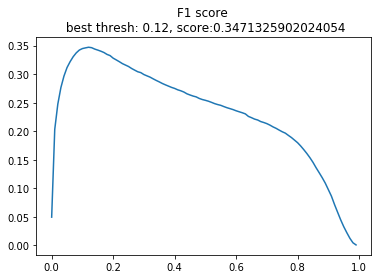

In [35]:
plotf1s(thresholds,f1s)